<a href="https://colab.research.google.com/github/Satwikram/Pneumonia-Detection-using-Vision-Transformers/blob/main/Notebooks/Pneumonia%20Detection%20using%20Vision%20Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Author: Satwik Ram K

Pneumonia Detection

![alt text](https://www.mayoclinic.org/-/media/kcms/gbs/patient-consumer/images/2016/05/18/13/02/ww5r032t-8col-jpg.jpg)

**Pneumonia Detection using 6000 Chest X-Ray HD Images.**
[link text](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)


**Chest X-Ray of Infected Person**![alt text](https://radiologyassistant.nl/assets/chest-x-ray-lung-disease/a51a0976c3619b_TAB-density-new.jpg)

**Chest X-Ray of healthy Person**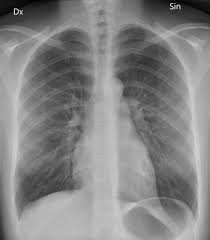

### Setup

In [ ]:
!pip install transformers

### Connecting to Kaggle

In [2]:
from google.colab import files

files.upload()

! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


### Downloading Dataset

In [3]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [01:42<00:00, 21.6MB/s]
100% 2.29G/2.29G [01:42<00:00, 24.1MB/s]


In [ ]:
!unzip /content/chest-xray-pneumonia.zip

### Importing Dependencies

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import string
import re

import os
from pathlib import Path

import matplotlib.pyplot as plt
import cv2

from tensorflow.keras.layers import Dense, Input, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling1D, BatchNormalization, Embedding, Bidirectional, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard



from sklearn.model_selection import train_test_split

from unicodedata import normalize

from tqdm import tqdm

from PIL import Image

from transformers import ViTFeatureExtractor, TFViTForImageClassification

import plotly.express as px
from datetime import date

from sklearn.metrics import *

import joblib

### Global Variables

In [2]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 224 #Setting all the images to 224 pixels

### # Function to get data

In [3]:
def get_data(data_dir):
  
  data = []

  for label in labels:
    path = os.path.join(data_dir, label)
    class_num = labels.index(label)

    for img in os.listdir(path):
      try:
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)

        resized_array = cv2.resize(img_array, (img_size, img_size))
        resized_array = resized_array / 255.0

        data.append([resized_array, class_num])

      except Exception as e:
        pass

  return data

In [4]:
# Getting train data
train = get_data('chest_xray/train')

# Getting test data
test = get_data('chest_xray/test')

# Getting Validadtion Data
val = get_data('chest_xray/val')

### Counting total numbers of images

In [5]:
def count(data):
  pneumonia = 0 
  normal = 0 

  for i, j in data:
    if j == 0:
      pneumonia += 1

    else:
      normal += 1

  print("Pneumonia Images:", pneumonia)
  print("Normal Images:", normal)
  print("Total Images:", pneumonia + normal)

In [6]:
count(train)

Pneumonia Images: 3875
Normal Images: 1341
Total Images: 5216


In [7]:
count(test)

Pneumonia Images: 390
Normal Images: 234
Total Images: 624


In [8]:
count(val)

Pneumonia Images: 8
Normal Images: 8
Total Images: 16


### Taking X and Y

In [9]:
X = []
y = []

# For training data
for feature, label in train:
  X.append(feature)
  y.append(label)


# For test data
for feature, label in test:
  X.append(feature)
  y.append(label)

### Shuffel the data and split the data into train and test

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, shuffle=True, stratify=y)

### Feature Extraction

In [11]:
checkpoint = "google/vit-base-patch16-224"

In [12]:
def feature_extraction(samples):
  
  feature_extractor = ViTFeatureExtractor.from_pretrained(checkpoint)

  return feature_extractor(samples, return_tensors="np")["pixel_values"]